### ARIMA - The Core Idea

ARIMA simulate time-dependent data by capturing three main components:

1. AR (AutoRegressive) — the relationship between an observation and several of its own lagged (past) values.  
    - Example: today’s stock price might depend on prices from the past 3 days.  
    - Parameter: p = number of lag observations (autoregressive terms).  

2. I (Integrated) — makes the time series stationary by differencing it (subtracting the previous value from the current one).
    - Non-stationary data means the mean, variance, or trend changes over time.
    - Parameter: d = number of differencing steps needed to make the data stationary.

3. MA (Moving Average) — models the relationship between an observation and the residual errors from previous forecasts.  
    - It smooths short-term fluctuations.
    - Parameter: q = size of the moving average window.

So the model is written as:  $ ARIMA(p,d,q)$

| Parameter  | Description                                            | Effect                                             |
| ---------- | ------------------------------------------------------ | -------------------------------------------------- |
| **p (AR)** | how many **past observations** to use                  | too high = overfitting; too low = underfitting     |
| **d (I)**  | how many **differences** to make the series stationary | too high = lose signal; too low = model sees trend |
| **q (MA)** | how many **past errors** to include                    | controls short-term shock smoothing                |


In [ ]:
## If people is looking for a more dynamic folder structure we can try this 

# ##### ===== System Setup ==== ##### 

# %load_ext dotenv
# %dotenv

# import os, sys
# from utils.logger import get_logger
# from datetime import datetime

# _logs = get_logger(__name__)
# _logs.info(f"Hello World! Today is {datetime.now().strftime('%A, %B %d, %Y')}")

# sys.path.append(os.getenv('SRC_DIR'))

In [1]:
##### >>> 1: Testing with APPL(Apple)
## >> 1.1 Load Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.auto import tqdm


/home/yikai/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## >> 1.3 Load the price data, AAPL 
FILE_PATH = "../../data/raw"
RAW_FILE = os.path.join(FILE_PATH, "prices-split-adjusted.csv")

Tick = 'AAPL'

df = pd.read_csv(RAW_FILE, parse_dates=["date"])
df['symbol'].unique()

print(f"Ticker: {Tick}")
print(f"Data Exist: {Tick in df['symbol'].unique() }")

df = df[df["symbol"] == Tick].sort_values("date")  # Example: AAPL
df = df[["date", "close"]].set_index("date")
df.tail() # only close as Y for predicton 

Ticker: AAPL
Data Exist: True


,close
date,
2016-12-23,116.519997
2016-12-27,117.260002
2016-12-28,116.760002
2016-12-29,116.730003
2016-12-30,115.820000


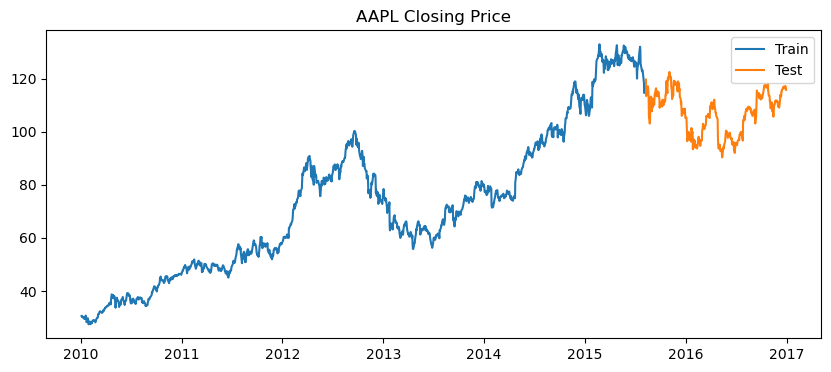

/home/yikai/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yikai/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yikai/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yikai/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is availab

ARIMA MSE: 134.3639
ARIMA MAE: 9.0984


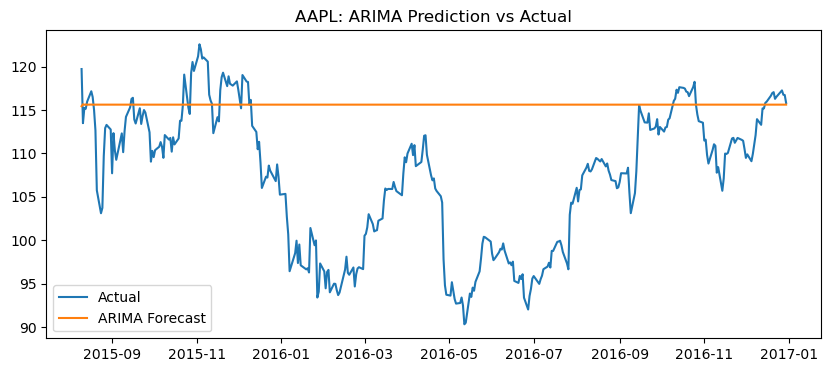

In [3]:
## >> 1.4 80/20 train-test split + ARIMA 
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.title(f"{Tick} Closing Price")
plt.show()

## >> 1.5 ARIMA Model (baseline)
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order=(5,1,0))
fit_arima = model_arima.fit()

pred_arima = fit_arima.forecast(steps=len(test))
mse_arima = mean_squared_error(test, pred_arima)
mae_arima = mean_absolute_error(test, pred_arima)

print(f"ARIMA MSE: {mse_arima:.4f}")
print(f"ARIMA MAE: {mae_arima:.4f}")

plt.figure(figsize=(10,4))
plt.plot(test.index, test["close"], label="Actual")
plt.plot(test.index, pred_arima, label="ARIMA Forecast")
plt.legend()
plt.title(f"{Tick}: ARIMA Prediction vs Actual")
plt.show()


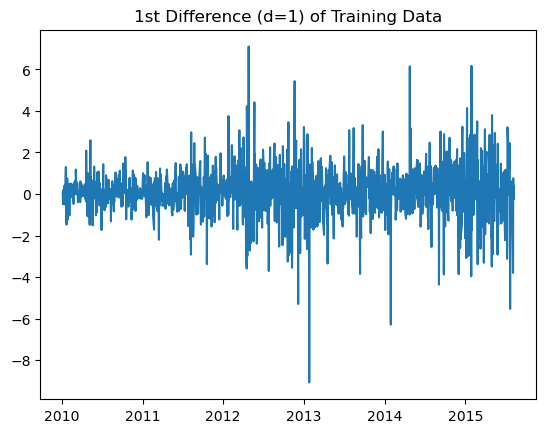

In [4]:
train_diff = train['close'].diff().dropna()
plt.plot(train_diff)
plt.title("1st Difference (d=1) of Training Data")
plt.show()

# If it looks random — no clear autocorrelation — ARIMA will not produce meaningful forecasts.

### > Quick note: 

The above graph show no **clear autocorrelation** as the “flat line” prediction from ARIMA is actually a very common issue, especially when first using it on stock data. After differencing (d=1), stock returns are mostly white noise — meaning no predictable structure. In short, ARIMA then outputs a constant mean forecast (flat line) because there’s nothing to learn statistically.

**Solution**: using `pmdarima` to automatic the process.  
<br><br>

In [ ]:
!pip install pmdarima

In [ ]:
##### >>> 2. Using Auto_ARIMA 

from pmdarima import auto_arima

## >> 2.1 80/20 train-test split + ARIMA training
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.title(f"{Tick} Closing Price")
plt.show()


auto_model = auto_arima(train['close'],
                        start_p=0, max_p=5,
                        start_q=0, max_q=5,
                        d=None,           # auto determine differencing
                        seasonal=False,   # non-seasonal data
                        trace=True,
                        information_criterion='aic',
                        stepwise=True)

print(auto_model.summary())


In [ ]:
## >> 2.2 Fit ARIMA Model (baseline) # using the auto
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order=(0,1,0))
fit_arima = model_arima.fit()

pred_arima = fit_arima.forecast(steps=len(test))
mse_arima = mean_squared_error(test, pred_arima)
mae_arima = mean_absolute_error(test, pred_arima)

print(f"ARIMA MSE: {mse_arima:.4f}")
print(f"ARIMA MAE: {mae_arima:.4f}")

plt.figure(figsize=(10,4))
plt.plot(test.index, test["close"], label="Actual")
plt.plot(test.index, pred_arima, label="ARIMA Forecast")
plt.legend()
plt.title(f"{Tick}: ARIMA Prediction vs Actual")
plt.show()



In [ ]:
##### >>> 3. Using rolling window 
# Window 1: train last 10 days -> forecast day 11
# Window 2: train days 2–11 -> forecast day 12
# Window 3: train days 3–12 -> forecast day 13
...

## >> 3.1 setup parameters

# Parameters
window_size = 30  # number of days used for training each step
tick = "AAPL"

# Prepare data
rolling_indices = range(window_size, len(df))
train_slices = [df['close'].iloc[i-window_size:i] for i in rolling_indices]
actual_values = df['close'].iloc[window_size:].values


## >> 3.2 fit model 
rolling_forecasts = []

for slice in tqdm(train_slices):
    # Option 1: Use auto_arima to select best order
    model = auto_arima(train_slice, start_p=0, max_p=3,
                       start_q=0, max_q=3, d=None,
                       seasonal=False, stepwise=True,
                       suppress_warnings=True)
    
    # Fit ARIMA with selected order
    fit = ARIMA(train_slice, order=model.order).fit()
    
    # Next-day forecast
    forecast = fit.forecast(steps=1).iloc[0]
    rolling_forecasts.append(forecast)


In [ ]:
## >> 3.3 predict 
forecast_dates = df.index[window_size:window_size + len(rolling_forecasts)]
rolling_forecasts_series = pd.Series(rolling_forecasts, index=forecast_dates)
actual_series = pd.Series(actual_values, index=forecast_dates)



In [ ]:
print(model.order)

In [ ]:
## >> 3.4 plot

plt.figure(figsize=(12,5))
plt.plot(actual_series, label="Actual")
plt.plot(rolling_forecasts_series, label="Predicted")
plt.title(f"{tick} Next-day Rolling ARIMA Forecast (window={window_size})")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
## >> 3.2 Fit model 
# Fit auto_arima on the window

model = auto_arima(train_slice, 
                   start_p=0, max_p=6, 
                   start_q=0, max_q=6, 
                   d=None, seasonal=False, 
                   stepwise=True, suppress_warnings=True)


print(model.summary())

# Fit ARIMA using the best order
print(model.order)
arima_order = model.order
fit = ARIMA(train_slice, order=arima_order).fit()

# Forecast next day
forecast = fit.forecast(steps=1).iloc[0]

rolling_forecasts.append(forecast)
actuals.append(actual_value)

In [ ]:
print(len(df.index[window_size:]), len(rolling_forecasts), len(actuals))

In [ ]:
## >> 3.3 Convert to arrays for metrics

y_true = np.array(actuals)
y_pred = np.array(rolling_forecasts)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Rolling-window ARIMA MSE: {mse:.4f}")
print(f"Rolling-window ARIMA MAE: {mae:.4f}")


In [ ]:
print(len(df))        # total rows
print(window_size)    # rolling window


In [ ]:
## >> 3.4 Plot results

x = df.index[window_size:]
plt.figure(figsize=(12,5))
plt.plot(x, y_true, label="Actual")
plt.plot(x, y_pred, label="Predicted")
plt.title(f"{tick} Next-day Rolling ARIMA Forecast")
plt.legend()
plt.show()


In [ ]:
window_size = 30
i = window_size
train_slice = df['close'].iloc[i-window_size:i]
print(train_slice)
